# stmfootball notebook

This notebook is designed as a chronological log of the approaches used to select a team.

In [1]:
# Import all the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns

sns.set_theme()
# YUCK!
import sys
import os
sys.path.append(os.getcwd() + "/src")
import src as football
from src.core import Season
from src.player import Player, Position
from src.experiments import SquadOptimiserExperiment, PredictorExperiment

## Approach

The approach we'll take in this notebook is as follows:

* Using the data before (and including) the 2021-22 season, try and train an model for optimising the number of points our fantasy team gets.
* Test this model on the 2022-23 season without hyperparamter tuning
* Deploy model on 2023-24 season

## Step 1: Explore the data

We are first going to start by exploring the 2021-2022 season of data to see what we have access to:

In [2]:
stats_2021_2022  = Path("./data/data/2021-22/players_raw.csv")
df = pd.read_csv(stats_2021_2022)
df.head()

,assists,bonus,bps,chance_of_playing_next_round,chance_of_playing_this_round,clean_sheets,code,corners_and_indirect_freekicks_order,corners_and_indirect_freekicks_text,cost_change_event,...,threat_rank_type,total_points,transfers_in,transfers_in_event,transfers_out,transfers_out_event,value_form,value_season,web_name,yellow_cards
0,0,0,69,100.0,100.0,1,80201,NaN,NaN,0,...,60,10,80974,0,205566,0,0.0,2.2,Leno,0
1,0,0,0,0.0,0.0,0,115918,NaN,NaN,0,...,19,0,19017,0,81363,0,0.0,0.0,Rúnarsson,0
2,0,0,0,0.0,0.0,0,47431,NaN,NaN,0,...,307,0,914,0,20541,0,0.0,0.0,Willian,0
3,1,7,131,0.0,0.0,6,54694,NaN,NaN,0,...,25,44,742898,0,900060,0,0.0,4.6,Aubameyang,3
4,1,3,292,100.0,100.0,3,58822,2.0,NaN,0,...,105,48,66997,0,55154,0,0.8,11.4,Cédric,3


It looks like a fairly even distribution of points across all the positions:

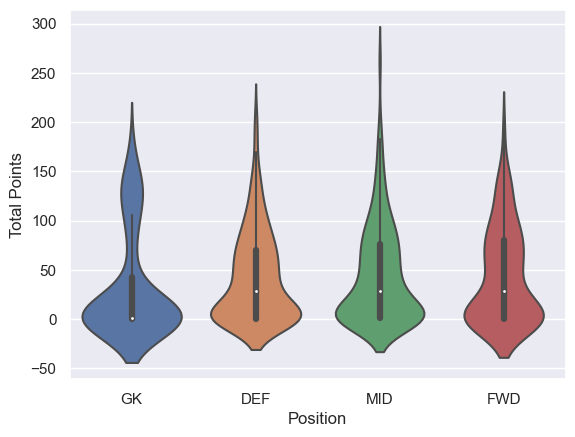

In [3]:
ax = sns.violinplot(
    data=df,
    x="element_type",
    y="total_points",
)
ax.set_xticklabels(["GK", "DEF", "MID", "FWD"])
ax.set_xlabel("Position")
ax.set_ylabel("Total Points")
plt.show()

By plotting the cost of a player against the number of points they get, see most people lie in a main cluster, with some outliers.

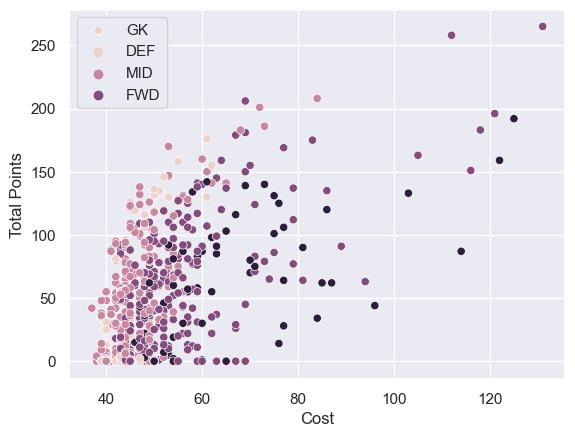

In [4]:
ax = sns.scatterplot(
    data=df,
    x="now_cost",
    y="total_points",
    hue="element_type",
)
ax.set_xlabel("Cost")
ax.set_ylabel("Total Points")
ax.legend(labels=["GK", "DEF", "MID", "FWD"])

Now let's make a new column on cost per point:

In [5]:
df["ppm"] = df["total_points"] / df["now_cost"]
df.sort_values(by="ppm", ascending=False).head(5)[["id", "first_name", "second_name", "ppm"]]

,id,first_name,second_name,ppm
373,224,Joel,Matip,3.207547
681,420,Jarrod,Bowen,2.985507
702,429,Conor,Coady,2.936170
380,231,Alisson,Ramses Becker,2.885246
579,353,Hugo,Lloris,2.872727


This is a slightly misleading direction and isn't what we're going to be the first strategy off, since players with a very small cost and average points gained might not be the best fit for the team, as we want to use as much of the budget as possible.

Let's however, take a look at the top 5's performance over time:

In [6]:
joel_matip = Player.from_pandas_row(df[df["second_name"] == "Matip"].iloc[0])

seasons = [Season.S2016_17, Season.S2017_18, Season.S2018_19, Season.S2019_20, Season.S2020_21]
history = joel_matip.get_historic_points_by_season(seasons)
print(history)

{2016/17: 97, 2017/18: 81, 2018/19: 83, 2019/20: 39, 2020/21: 42}


Now let's predict the number of points he'll get via a linear regression model (note the last point in this plot is on the line because it's predicted). The actual points he got is in red.

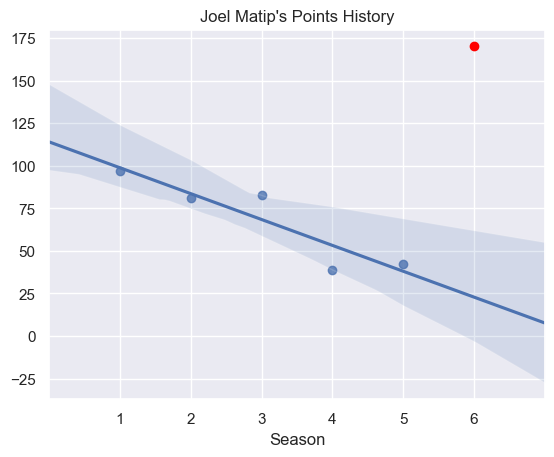

In [7]:
# Plot seasons that a model will see
fig, ax = plt.subplots()
ax.set_xlim((0, max(season.value for season in seasons) + 2))
ax = sns.regplot(x=[season.value for season in seasons], y=list(history.values()), ax=ax, truncate=False)
ax.set_title("Joel Matip's Points History")
ax.set_xlabel("Season")
ax.set_xticks([season.value for season in seasons] + [max(season.value for season in seasons) + 1])

# Plot actual value of 2021/22
next_season = Season(max(season.value for season in seasons) + 1)
ax.scatter([next_season.value], [sum(joel_matip.get_historic_points_for_season(next_season))], color="red")


Looks like he had a good year!

Let's apply this to every row in the dataframe, and sort by the players who outperformed their expected values

In [8]:
seasons = [Season.S2016_17, Season.S2017_18, Season.S2018_19, Season.S2019_20, Season.S2020_21]
df = football.analysis.add_predicted_points_to_df(df, seasons)
df["Point Delta"] = df["total_points"] - df["predicted_points"]
df.sort_values(by="Point Delta", ascending=False).head(20)[["id", "first_name", "second_name", "Point Delta"]]

,id,first_name,second_name,Point Delta
415,256,João Pedro Cavaco,Cancelo,201.0
213,138,Mason,Mount,169.0
221,529,Romelu,Lukaku,168.6
466,579,Cristiano Ronaldo,dos Santos Aveiro,159.0
448,277,Bruno Miguel,Borges Fernandes,151.0
373,224,Joel,Matip,147.2
60,44,Matthew,Cash,147.0
20,23,Gabriel,Magalhães,146.0
723,475,José,Malheiro de Sá,146.0
348,196,Raphael,Dias Belloli,145.0


Let's plot this to have a look - we would expect the means to be around 0 as a similar number of players should over-perform as they do under-perform

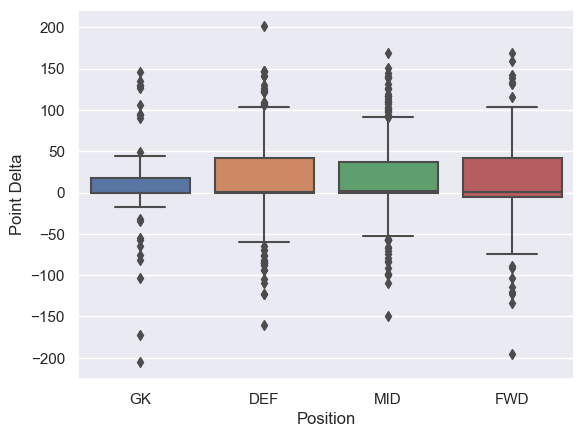

In [9]:
ax = sns.boxplot(
    data=df,
    x="element_type",
    y="Point Delta",
)

ax.set_xticklabels(["GK", "DEF", "MID", "FWD"])
ax.set_ylabel("Point Delta")
ax.set_xlabel("Position")
plt.show()

We've got some idea on what our data looks like now - we have a *very important* score (`total_points`) that we need to maximise for each player in our squad. How we do that is subject to some constraints (budget, team format, rules etc).

## Selecting an inital squad


We have two things to consider from now on - each player is taken in isolation so we don't have to worry about combinations of players.

* How do we value the players? We want to predict the amount of points they'll give us, and act accordingly
* How do we select the players based on their value? We could do this perfectly using an extension of a [Multiple Choice Knapsack Problem](https://link.springer.com/chapter/10.1007/978-3-540-24777-7_11), but this is algorithmically infeasible. So we need to approximate!

We use the following structures:

* The `Player` class implements a `predict_points_for_next_season` function that outputs some number representing an estimated value for the player in the next season. TODO: Port this out into a class
* The `SquadOptimiser` class (and it's children) define methods of taking the above values in the dataframe and selecting initial players based on an algorithm.

We start with two defaults:
* Linear Regression from previous data for the `predict_points_for_next_season` function
* A so-called `Efficient` algorithm that attempts to build a team from the "best value for money" players.

In [10]:
SquadOptimiserExperiment().run(
    df,
    [
        football.squad_optimisers.Efficient,
        football.squad_optimisers.Efficientv2,
        football.squad_optimisers.Average,
        football.squad_optimisers.Random,
    ],
    cost_col="now_cost",
    points_col="total_points",
)


,squad_optimiser,squad_total_points,team_total_points,squad_cost,team_cost,squad
0,Efficient,2403,1818,904,668,"[Alisson Ramses Becker, Bukayo Saka, Conor Coa..."
1,Efficientv2,2376,1818,902,668,"[Alisson Ramses Becker, Bukayo Saka, Conor Coa..."
2,Average,769,489,750,550,"[Andriy Yarmolenko, Christian Nørgaard, David ..."
3,Random,540,437,751,570,"[Aaron Wan-Bissaka, Adama Traoré, Andreas Chri..."


In [11]:
historical_data = []

seasons = [
    Season.S2016_17,
    Season.S2017_18,
    Season.S2018_19,
    Season.S2019_20,
    Season.S2020_21,
    Season.S2021_22,
    Season.S2022_23,
]

for _, row in df.iterrows():
    player = Player.from_pandas_row(row)
    historic_player = player.get_historic_points_by_season(seasons)
    historical_data.append(list(historic_player.values()))

historical_data = np.array(historical_data)
current_data = historical_data[:, -1]
historical_data = historical_data[:, :-1]

PredictorExperiment().run(
    historic_data=historical_data,
    current_data=current_data,
    predictors=[
        football.predictors.LSTMPredictor,
        football.predictors.ARIMAPredictor,
        football.predictors.LinearPredictor,
    ]
)

Running predictor: LSTM
24/24 [==============================] - 0s 618us/step
Running predictor: ARIMA
Running predictor: LinearRegression


,predictor,mse
0,LSTM,1614.625853
1,ARIMA,4765.977213
2,LinearRegression,2652.543253


# Baseline Squad Generation

Let's come up with an emergency squad for this coming season then.

In [12]:
seasons = [Season.S2016_17, Season.S2017_18, Season.S2018_19, Season.S2019_20, Season.S2020_21, Season.S2021_22, Season.S2022_23]

player_path = Path("data/data/2023-24/players_raw.csv")
df = pd.read_csv(player_path)
df = football.analysis.add_predicted_points_to_df(df, seasons[:-1])

optim = football.squad_optimisers.Efficientv2(
    cost_col="now_cost", 
    points_col="predicted_points",
    budget_breakdown={
        Position.GK : 250,
        Position.DEF : 250,
        Position.MID : 250,
        Position.FWD : 250
    }
).optimise(df)

In [13]:
[p.name for p in optim]

['Alisson Ramses Becker',
 'Vicente Guaita',
 'Tyrone Mings',
 'Andrew Robertson',
 'Lucas Digne',
 'Matt Targett',
 'Trent Alexander-Arnold',
 'Danny Ings',
 'Chris Wood',
 'Mason Mount',
 'Jarrod Bowen',
 'James Maddison',
 'Neal Maupay',
 'Youri Tielemans',
 'Harvey Barnes']

In [14]:
df["full name"] = df["first_name"] + " " + df["second_name"]
only_squad = df[df["full name"].isin([p.name for p in optim])]
only_squad.sort_values(by="predicted_points", ascending=False)

,assists,bonus,bps,chance_of_playing_next_round,chance_of_playing_this_round,clean_sheets,clean_sheets_per_90,code,corners_and_indirect_freekicks_order,corners_and_indirect_freekicks_text,...,transfers_in_event,transfers_out,transfers_out_event,value_form,value_season,web_name,yellow_cards,predicted_points,value,full name
308,11,21,824,NaN,NaN,10,0.31,169187,1.0,NaN,...,0,0,0,0.0,19.5,Alexander-Arnold,5,267.933333,3.349167,Trent Alexander-Arnold
309,1,15,824,NaN,NaN,14,0.38,116535,NaN,NaN,...,0,0,0,0.0,29.5,Alisson,1,226.933333,4.126061,Alisson Ramses Becker
538,9,9,520,NaN,NaN,4,0.15,172780,NaN,NaN,...,0,0,0,0.0,18.0,Maddison,10,225.200000,3.002667,James Maddison
325,8,10,633,NaN,NaN,9,0.31,122798,2.0,NaN,...,0,0,0,0.0,18.6,Robertson,3,222.466667,3.422564,Andrew Robertson
394,4,8,277,NaN,NaN,8,0.44,184341,NaN,NaN,...,0,0,0,0.0,11.7,Mount,4,217.800000,3.111429,Mason Mount
561,9,9,431,NaN,NaN,9,0.25,178186,1.0,NaN,...,0,0,0,0.0,20.7,Bowen,2,212.200000,3.031429,Jarrod Bowen
570,2,13,317,NaN,NaN,5,0.28,84939,NaN,NaN,...,0,0,0,0.0,16.2,Ings,4,188.200000,3.136667,Danny Ings
461,2,0,379,NaN,NaN,6,0.20,201666,NaN,NaN,...,0,0,0,0.0,21.2,Barnes,3,188.066667,2.893333,Harvey Barnes
239,0,10,484,NaN,NaN,6,0.22,40836,NaN,NaN,...,0,0,0,0.0,22.0,Guaita,1,179.133333,3.980741,Vicente Guaita
59,3,6,461,NaN,NaN,6,0.23,166989,NaN,NaN,...,0,0,0,0.0,14.3,Tielemans,4,177.466667,2.957778,Youri Tielemans
